In [1]:
import pandas as pd
import gzip
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# List of datasets to use
data = ['Resources/data/reviews_Digital_Music_5.json.gz', 'Resources/data/reviews_Digital_Music_5.json.gz']

# functions to read Amazon data into a pandas data frame
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# function to concatenate multiple Amazon datasets
def concatDF(data):
    df = pd.DataFrame()
    for dataset in data:
        dftemp = getDF(dataset)
        df = pd.concat([df, dftemp], axis=0)
    # drop unneeded columns
    df.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'helpful', \
                       'summary', 'unixReviewTime', 'reviewTime'], inplace= True)
    return df

In [5]:
df = concatDF(data)

In [6]:
df['sentiments'] = df.overall.apply(lambda x: 0 if x in [1, 2] else 1)

In [7]:
df.head()

,reviewText,overall,sentiments
0,"It's hard to believe ""Memory of Trees"" came ou...",5.0,1
1,"A clasically-styled and introverted album, Mem...",5.0,1
2,I never thought Enya would reach the sublime h...,5.0,1
3,This is the third review of an irish album I w...,5.0,1
4,"Enya, despite being a successful recording art...",4.0,1


In [8]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [9]:
split = round(len(df)*0.8)
train_reviews = df['reviewText'][:split]
train_label = df['sentiments'][:split]
test_reviews = df['reviewText'][split:]
test_label = df['sentiments'][split:]

In [10]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for row in train_reviews:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)
for row in test_reviews:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)

In [11]:
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [12]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [25]:
len(word_index)

136859

In [14]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,       input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_________________________________________________________________


In [18]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [19]:
num_epochs = 1
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

3236/3236 [==============================] - 19s 6ms/step - loss: 0.2391 - accuracy: 0.9234 - val_loss: 0.2418 - val_accuracy: 0.8980


<Figure size 432x288 with 0 Axes>

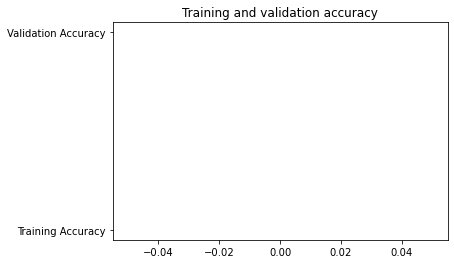

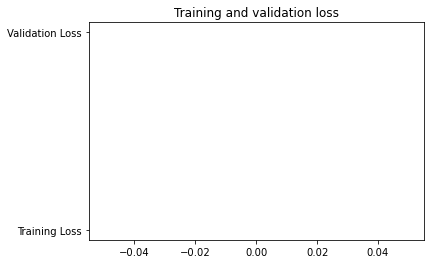

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()